## General

Data from Kaggle:
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

Team members:
- Куценко Антон
- Микаэлян Аик
- Соломоник Михаил 
- Францев Андрей
- Алексей Сек

## Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

1. radius (mean of distances from center to points on the perimeter)
2. texture (standard deviation of gray-scale values)
3. perimeter
4. area
5. smoothness (local variation in radius lengths)
6. compactness (perimeter^2 / area - 1.0)
7. concavity (severity of concave portions of the contour)
8. concave points (number of concave portions of the contour)
9. symmetry
10. fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

## Task: Predict whether is benign or malignant

# 0. Preparation

In [1]:
# Import all packages

import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst



import statsmodels as sm
import statsmodels.api as sma
smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from inspect import signature as sig
from IPython.display import clear_output



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_auc_score, recall_score, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve

import statsmodels.formula.api as smf

from inspect import signature

import statsmodels

import itertools

from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import dataset from kaggle
df = pd.read_csv('https://raw.githubusercontent.com/ontenkutsenko/Project_EAML/main/data.csv')

In [3]:
# Check whether all columns are displayed correctly
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.shape

(569, 33)

In [ ]:
# We see that id seems to be just an id of observation and using common sense we can understand that it cannot be a predictor in our model
# Also, the last column seems to be full of missing values, so let's drop it for simplicity

# All values are missing in the last column
sum(df['Unnamed: 32'].isnull().values)

569

In [5]:
# Dropping 2 columns mentioned above

df = df.drop(columns=['id','Unnamed: 32'])
df.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
# Let's transform our target variable 'diagnosis' into 0 if benign and 1 if malign
# This seems to make sense when 0 is less dangerous tumor
LE = LabelEncoder()
LE.fit(df['diagnosis'])
df['diagnosis'] = LE.transform(df['diagnosis'])
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# 1. Exploratory data analysis

In [12]:
df.columns[0]

'diagnosis'

In [ ]:
# Let's check descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


In [ ]:
# We can see that there are more people with malign than with benign
# It should be taken into account when dividing our sample into train and test
plt.figure(figsize = (10,7))
sns.countplot(df['diagnosis'], palette= ['#f00768', "#130dd1"])
plt.title('Class distribution')-
plt.show()

SyntaxError: ignored

In [ ]:
# Let's check whether our factors are correlated
fig,ax = plt.subplots(figsize = (20,20))
sns.heatmap(df.corr(),annot=True,linewidths=0.5,fmt = ".2f",ax=ax)

From this correlation matrix we can make several conclusions:
1. Diagnosis has quite high correlations with predictors
2. There is multicollinearity as far as predictors are correlated with each other

In [ ]:
# Get column values of X and Y
columns = df.columns.values

x_col = columns[1:]
y_col = columns[0]

In [ ]:
columns

array(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'], dtype=object)

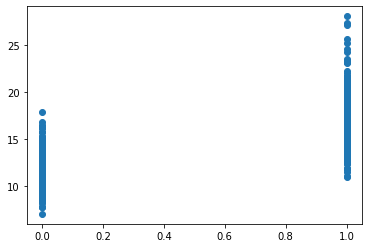

In [ ]:
plt.scatter(df[columns[0]],df[columns[1]])

## Pairplots analysis

**Description**
- On Pairplots diagonal we can see distribution of predictors by type of diagnosis
- Graphs that stand not in the diagonal show scatter plots of predictors divided by type of diagnosis

**Results**
- For some of the factors we an see that the disctribution of groups of diferent diagnosis are significantly different. So, it can be useful to make predictions

In [ ]:
# Let's create pairplots of with all factors for malign and benign breakdown

pp1 = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']

pp2 = ['diagnosis','compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean','fractal_dimension_mean']

pp3 = ['diagnosis','radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se']

pp4 = ['diagnosis','compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se','fractal_dimension_se']

pp5 = ['diagnosis','radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst']

pp6 = ['diagnosis','compactness_worst', 'concavity_worst', 'concave points_worst','symmetry_worst', 'fractal_dimension_worst']

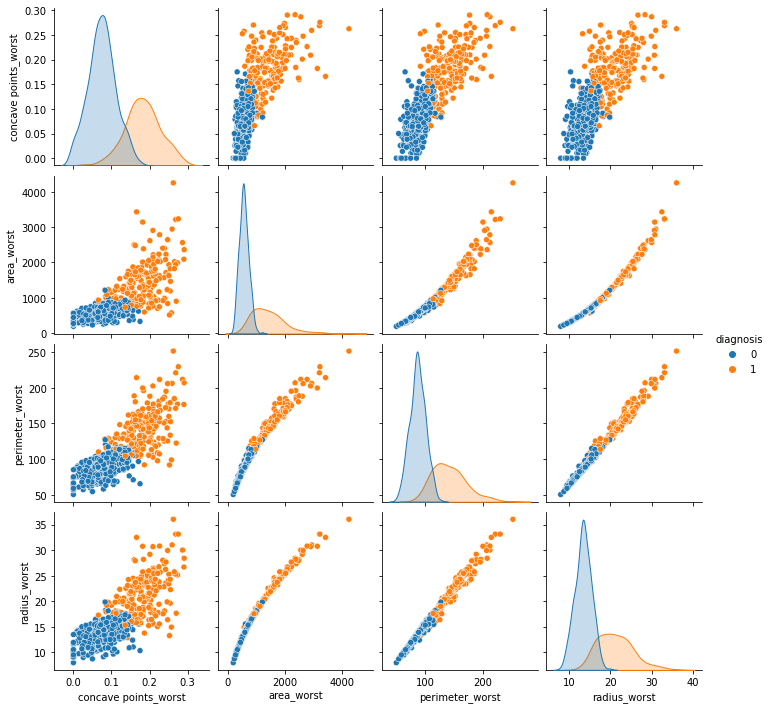

In [ ]:
pp7 = ['diagnosis','concave points_worst', 'area_worst', 'perimeter_worst', 'radius_worst' ]
sns.pairplot(df[pp7 ],hue='diagnosis')
plt.show()

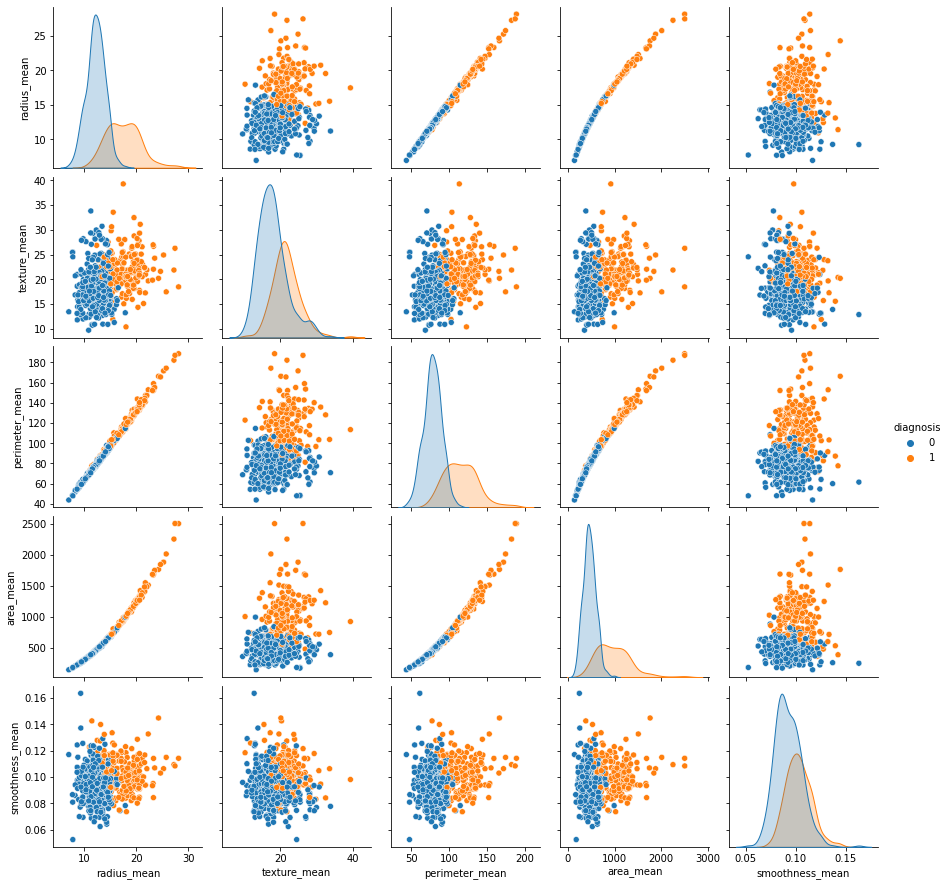

In [ ]:
sns.pairplot(df[pp1],hue='diagnosis')

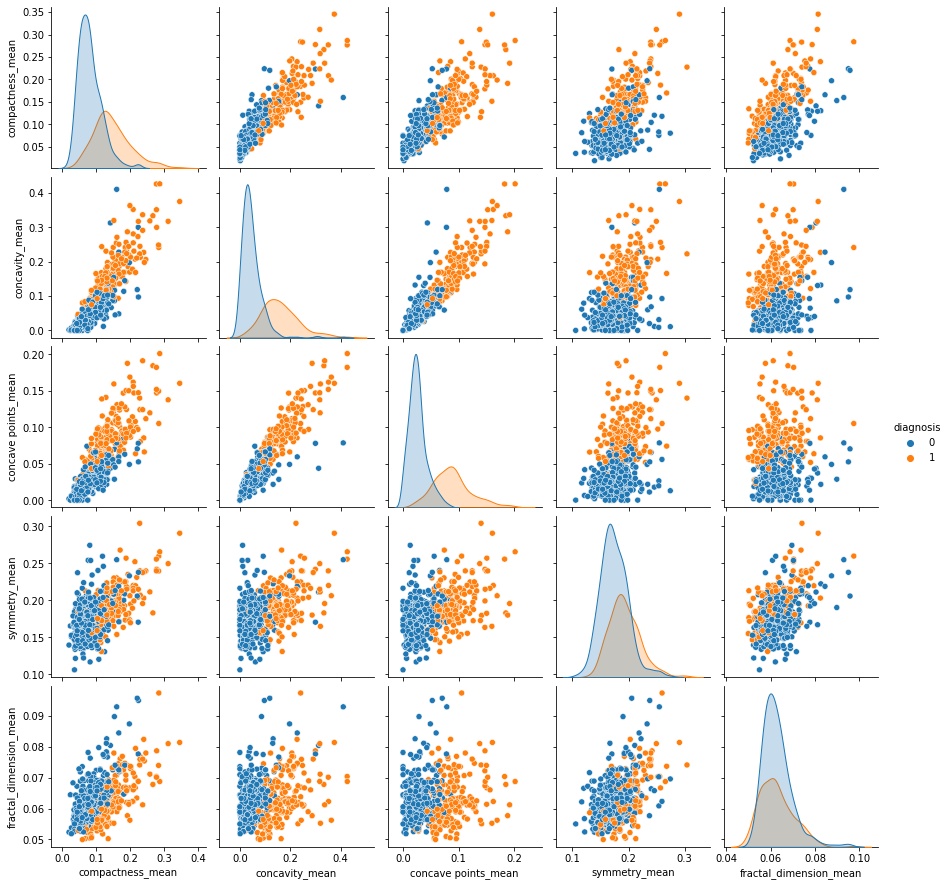

In [ ]:
sns.pairplot(df[pp2],hue='diagnosis')

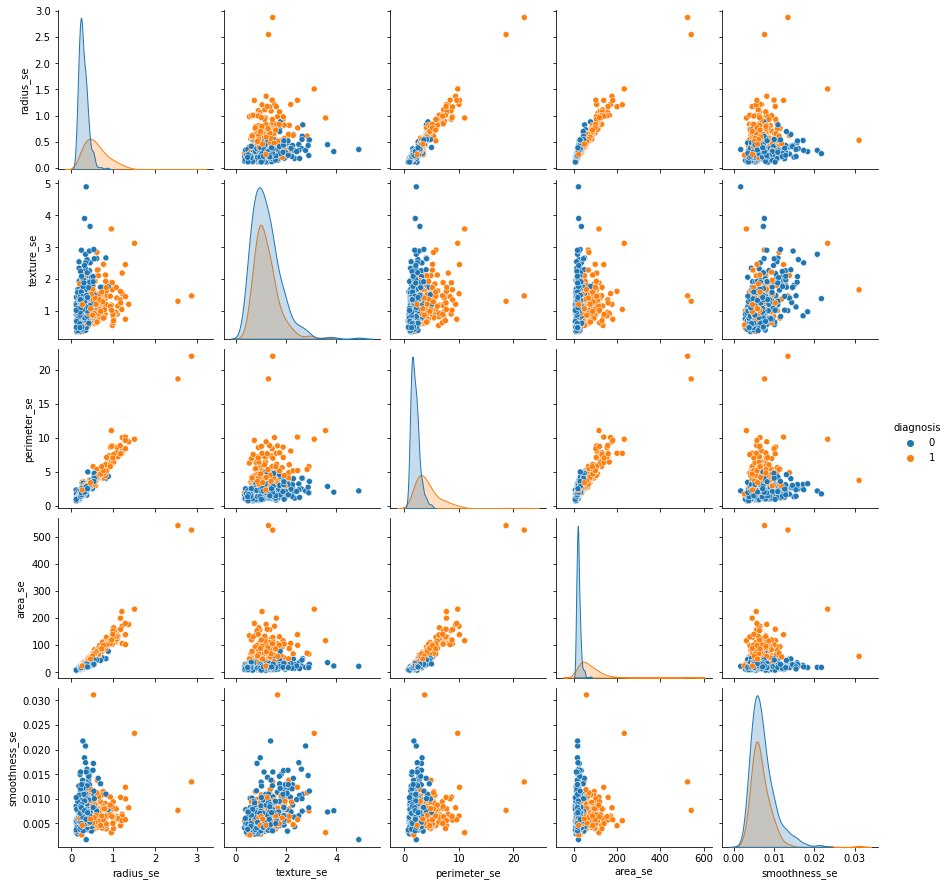

In [ ]:
sns.pairplot(df[pp3],hue='diagnosis')

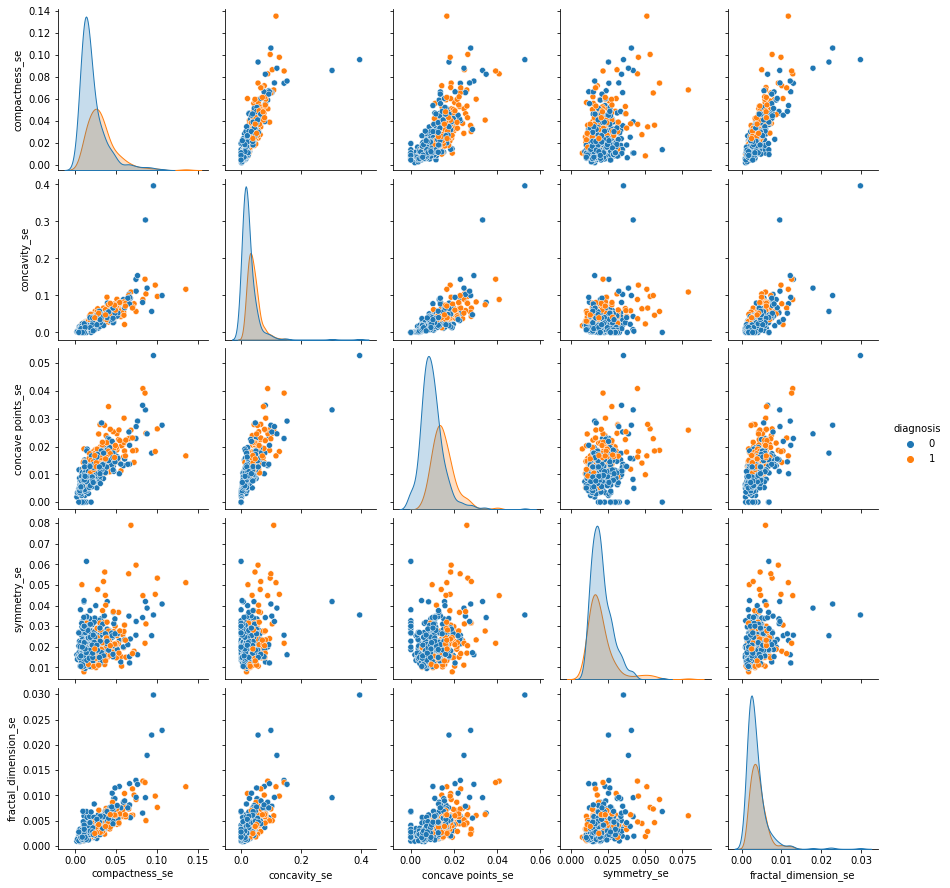

In [ ]:
sns.pairplot(df[pp4],hue='diagnosis')

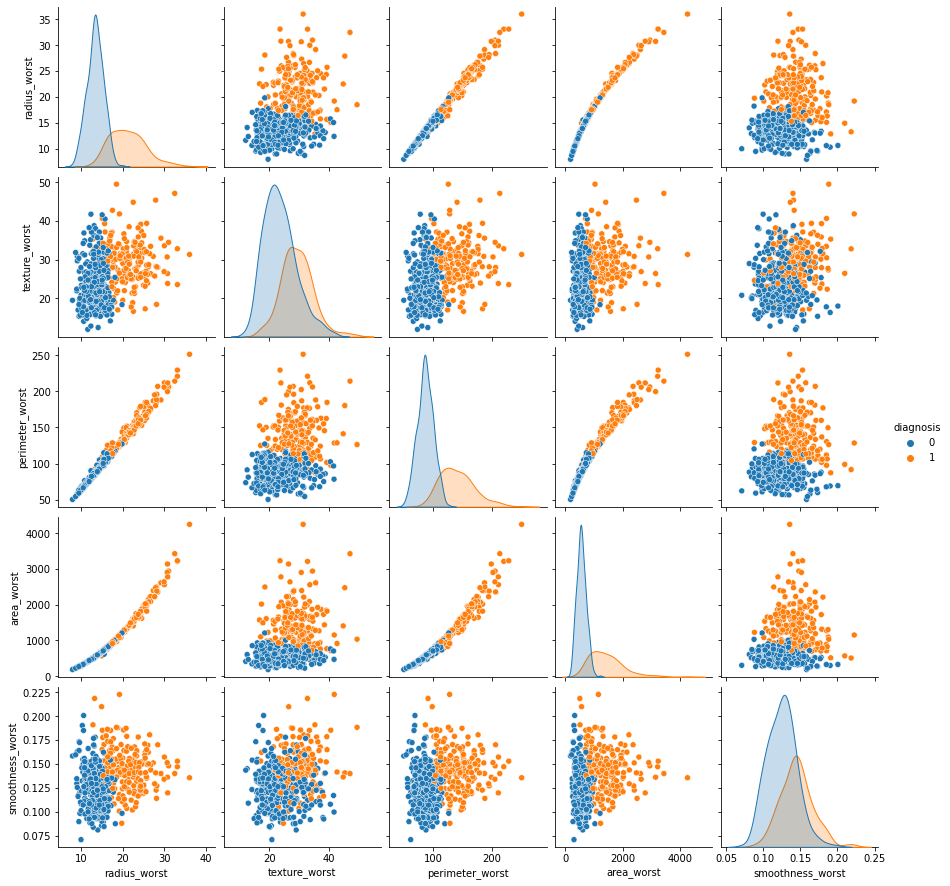

In [ ]:
sns.pairplot(df[pp5],hue='diagnosis')

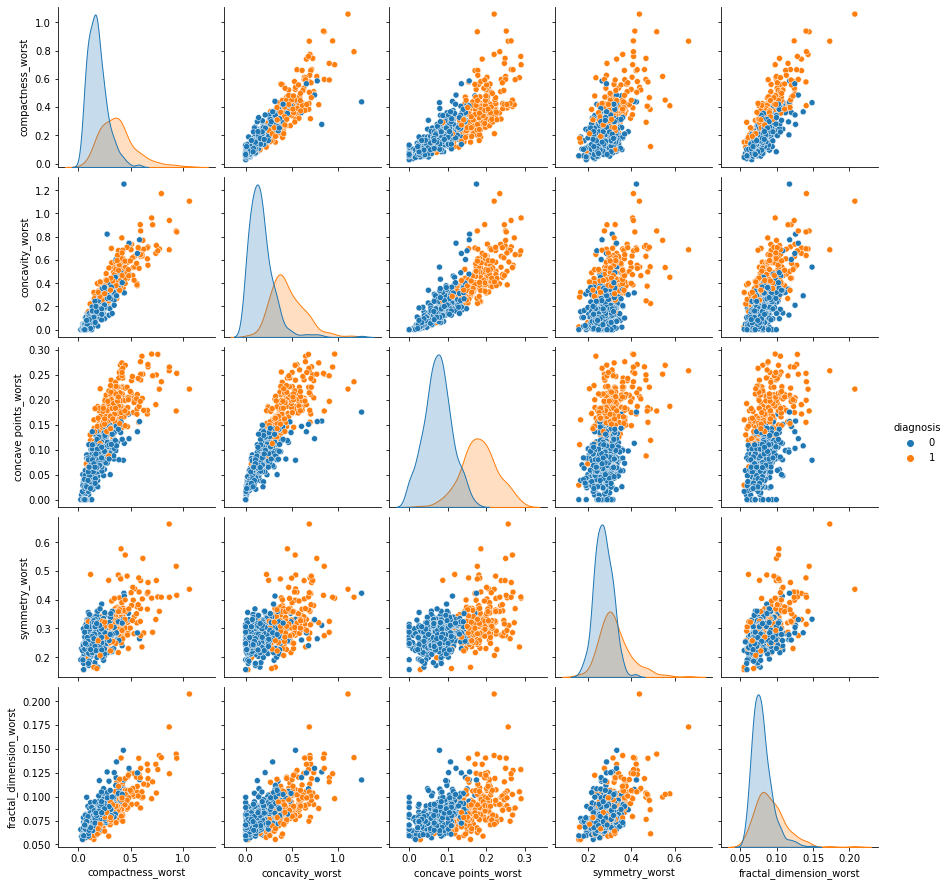

In [ ]:
sns.pairplot(df[pp6],hue='diagnosis')

# 2. Modelling

## 2.0. Splitting sample

In [16]:
scaler = StandardScaler()

In [17]:
#Let's create y and X and scale our features for faster convergence
y = df['diagnosis']
X = scaler.fit_transform(df[df.columns.drop('diagnosis')])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

## 2.1. Logistic Regression

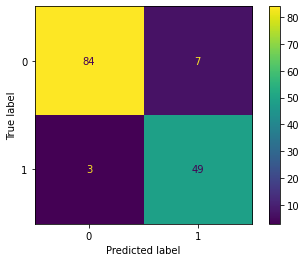

Accuracy:  0.93


In [27]:
#Let's build simple Logit
logreg = LogisticRegression(penalty='none',  max_iter = 10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
plot_confusion_matrix(logreg,X_test, y_test)
plt.show()
print('Accuracy: ', np.round(accuracy_score(y_test,y_pred),3))

In [ ]:
#Let's look for optimal penalty using grid serach
parameters = {'penalty':('l1', 'l2',  'none')}
logreg = LogisticRegression(solver = 'saga', max_iter = 10000)
clf = GridSearchCV(logreg, parameters, scoring='accuracy')
clf.fit(X, y)
clear_output()
print(clf.best_params_)
print(clf.best_score_)

{'penalty': 'l2'}
0.9789318428815402


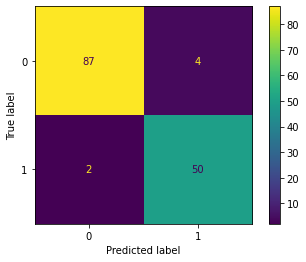

Accuracy:  0.958


In [ ]:
logreg = LogisticRegression(penalty=clf.best_params_['penalty'],  max_iter = 10000, solver = 'saga')
logreg.fit(X_train, y_train)
plot_confusion_matrix(logreg,X_test, y_test)
plt.show()
y_pred = logreg.predict(X_test)
print('Accuracy: ', np.round(accuracy_score(y_test,y_pred),3))

In [ ]:
prediction=logreg.predict_proba(X_test)[:,1]

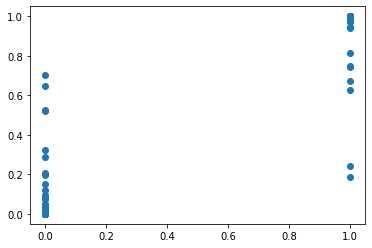

In [ ]:
plt.scatter(y_test, prediction)

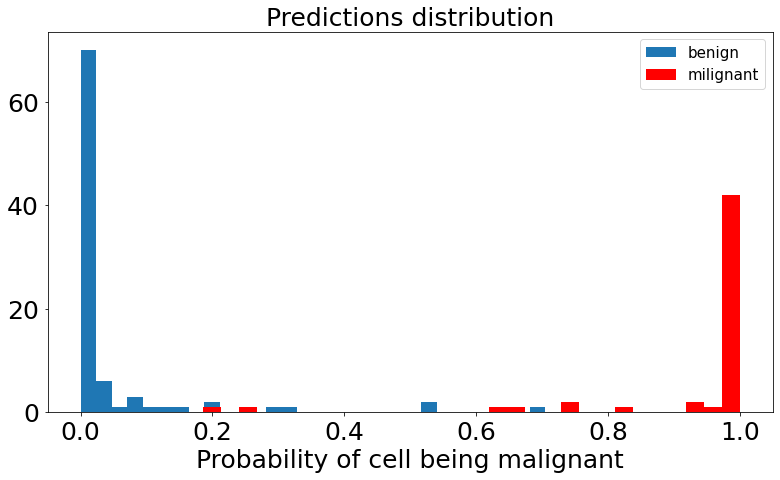

In [ ]:
plt.figure(figsize=(13,7))
plt.hist(prediction[y_test==0], bins=30, label='benign')
plt.hist(prediction[y_test==1], bins=30, label='milignant',  color='r')
plt.xlabel('Probability of cell being malignant', fontsize=25)
plt.title('Predictions distribution', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

## 2.2. SVM

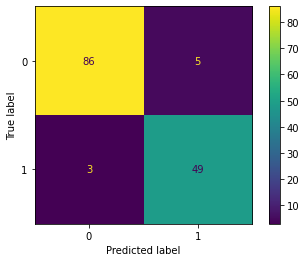

Accuracy:  0.944


In [ ]:
svc = SVC(kernel = 'linear')
svc.fit(X_train, y_train)
plot_confusion_matrix(svc,X_test, y_test)
plt.show()
y_pred = svc.predict(X_test)
print('Accuracy: ', np.round(accuracy_score(y_test,y_pred),3))

In [ ]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C': np.linspace(0.1,10,100)}
svc = SVC()
clf1 = GridSearchCV(svc, parameters, scoring='accuracy')
clf1.fit(X, y)
clear_output()
print(clf1.best_params_)
print(clf1.best_score_)

{'C': 6.0, 'kernel': 'rbf'}
0.9806862288464524


In [ ]:
svc = SVC(kernel =clf1.best_params_['kernel'], C = clf1.best_params_['C'],  max_iter = 10000)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('Accuracy: ', np.round(accuracy_score(y_test,y_pred),3))

Accuracy:  0.986


## 2.3. Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from time import time

simple_gb = GradientBoostingClassifier()
simple_gb.fit(X_train, y_train)
y_pred = simple_gb.predict(X_test)
accuracy_score(y_pred, y_test)

0.965034965034965

In [ ]:
acc_train = []
acc_test = []
time_list = []

n_list = np.arange(10,250,10)

for n in n_list:
    model_gb = GradientBoostingClassifier(n_estimators=n)

    t_start = time()
    model_gb.fit(X_train, y_train)

    pred_train = model_gb.predict(X_train)
    acc_train.append(accuracy_score(y_train, pred_train))
    
    pred_test = model_gb.predict(X_test)
    acc_test.append(accuracy_score(y_test, pred_test))

    t_end = time()

    time_list.append(t_end-t_start)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5, 1.0, 'Time')

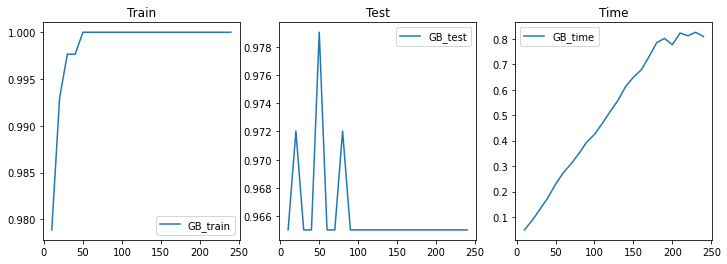

In [ ]:
from matplotlib import pylab as plt
%pylab inline

figure(figsize=(12, 4))
subplot(1, 3, 1)
plot(n_list, acc_train, label='GB_train')
plt.legend()
plt.title('Train')
plt.subplot(1, 3, 2)
plot(n_list, acc_test, label='GB_test')
plt.legend()
plt.title('Test')
plt.subplot(1, 3, 3)
plot(n_list, time_list, label='GB_time')
plt.legend()
plt.title('Time')

In [ ]:
gb = GradientBoostingClassifier(n_estimators=50)
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
}
CV_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy')
CV_gb.fit(X_train, y_train)

In [ ]:
CV_gb.best_params_

{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4}

In [ ]:
improved_gb = GradientBoostingClassifier(n_estimators=50, max_depth=8, max_features='sqrt', min_samples_leaf=4)
improved_gb.fit(X_train, y_train)
y_pred = improved_gb.predict(X_test)
accuracy_score(y_pred, y_test)

0.986013986013986

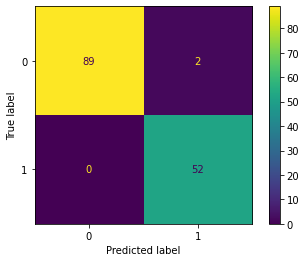

In [ ]:
plot_confusion_matrix(improved_gb,X_test, y_test)
plt.show()

## 2.4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9790209790209791

In [ ]:
rf_importances

radius_mean                0.065265
texture_mean               0.011172
perimeter_mean             0.062898
area_mean                  0.069559
smoothness_mean            0.005613
compactness_mean           0.009016
concavity_mean             0.058491
concave points_mean        0.081743
symmetry_mean              0.002879
fractal_dimension_mean     0.005064
radius_se                  0.014163
texture_se                 0.003734
perimeter_se               0.012040
area_se                    0.029712
smoothness_se              0.005465
compactness_se             0.007627
concavity_se               0.004502
concave points_se          0.003236
symmetry_se                0.003230
fractal_dimension_se       0.004003
radius_worst               0.072440
texture_worst              0.016569
perimeter_worst            0.087464
area_worst                 0.157731
smoothness_worst           0.012276
compactness_worst          0.019117
concavity_worst            0.035043
concave points_worst       0

In [ ]:
['concave points_worst', 'area_worst', 'perimeter_worst', 'radius_worst ' ]

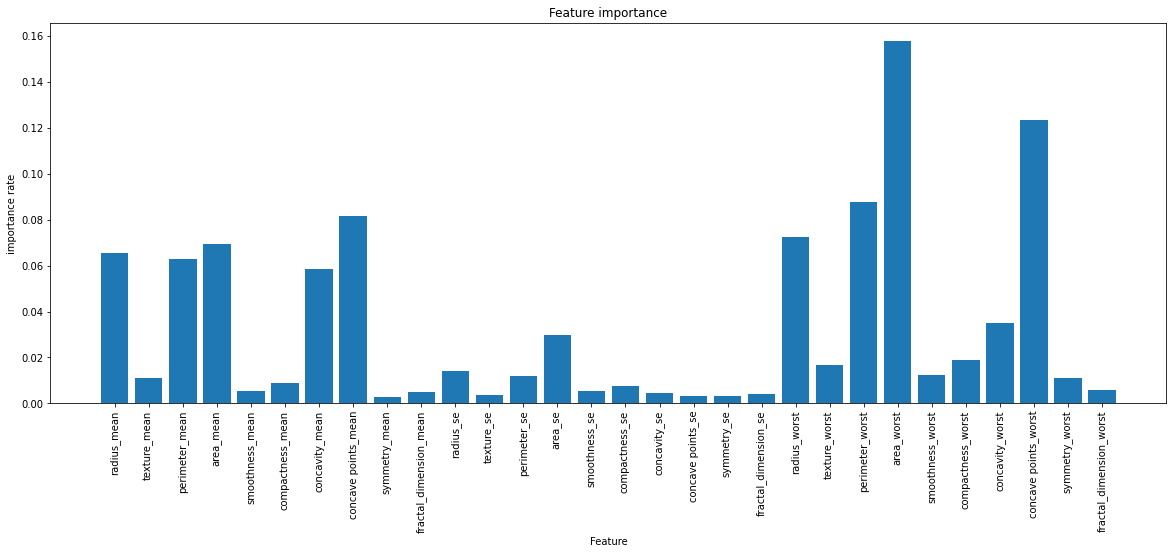

In [ ]:
feature_names = feature_names = [feature for feature in df.columns[1:]]
importances = rf.feature_importances_
rf_importances = pd.Series(importances, index=feature_names)
plt.figure(figsize=(20, 7))
plt.bar(feature_names, rf_importances)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('importance rate')
plt.title('Feature importance')
plt.show()

In [ ]:
rf=RandomForestClassifier(random_state=42)
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8,9,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 3, 4, 5],
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
CV_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
CV_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'log2',
 'min_samples_split': 3}

In [ ]:
rf_best=RandomForestClassifier(random_state=42, max_features='auto', max_depth=4, min_samples_split=4, criterion='entropy')
rf_best.fit(X_train,y_train)
y_pred=rf_best.predict(X_test)
accuracy_score(y_pred, y_test)

0.9790209790209791

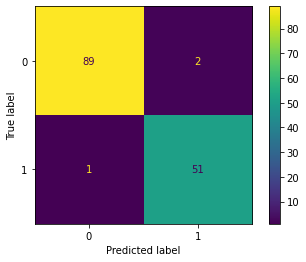

In [ ]:
plot_confusion_matrix(rf_best,X_test, y_test)
plt.show()


## 2.5. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [ ]:
# Let's use CV to define the best # of neighbors (hyperparameter)
param_grid = { 
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
}

CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
CV_knn.fit(X_train, y_train)
CV_knn.best_params_

{'n_neighbors': 3}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_optimal = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn_optimal.fit(X_train, y_train)
y_pred_knn = knn_optimal.predict(X_test)

accuracy_score(y_pred_knn, y_test)

0.986013986013986

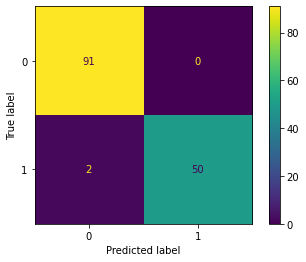

In [ ]:
plot_confusion_matrix(knn_optimal,X_test, y_test)
plt.show()


# 3. Summary